In [2]:
import numpy as np
from scipy.sparse import kron, lil_matrix
from scipy.sparse.linalg import eigsh, expm_multiply

# Pauli Matrix
Sx = np.array([[0, 1], [1, 0]])
Sz = np.array([[1, 0], [0, -1]])
I = np.eye(2)

def hamiltonian(L, h, J=1.0):
    H = lil_matrix((2**L, 2**L), dtype=np.complex128)
    for i in range(L):
        # zz
        left = [I]*L
        left[i] = Sz
        left[(i+1)%L] = Sz
        term = kron(left[0], left[1], format='csr')
        for j in range(2, L):
            term = kron(term, left[j], format='csr')
        H -= J * term
        # x
        left = [I]*L
        left[i] = Sx
        term = kron(left[0], left[1], format='csr')
        for j in range(2, L):
            term = kron(term, left[j], format='csr')
        H -= h * term
    return H.tocsr()

In [2]:
L = 12
h_values = [0.5, 1.0, 2.0]
for h in h_values:
    H = hamiltonian(L, h)
    E, psi = eigsh(H, k=2, which='SA')  # 最小实部
    print(f"h = {h}:")
    print(f"基态能量: {E[0]:.6f}, 第一激发态能量: {E[1]:.6f}")
    
    sigma_x_1 = lil_matrix((2**L, 2**L), dtype=np.complex128)
    left = [I]*L
    left[0] = Sx
    term = kron(left[0], left[1])
    for j in range(2, L):
        term = kron(term, left[j])
    sigma_x_1 = term
    
    expectation = psi[:, 0].conj().T @ sigma_x_1 @ psi[:, 0]
    print(f"s1x: {expectation.real:.6f}\n")

h = 0.5:
基态能量: -12.762497, 第一激发态能量: -12.762569
s1x: 0.258587

h = 1.0:
基态能量: -15.322595, 第一激发态能量: -15.191508
s1x: 0.638441

h = 2.0:
基态能量: -25.525138, 第一激发态能量: -23.524993
s1x: 0.934183



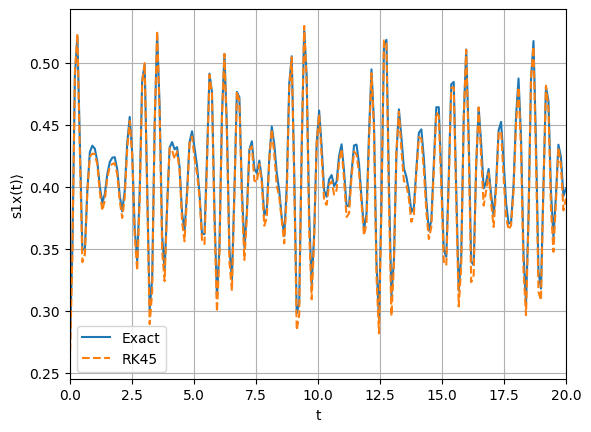

In [5]:
from scipy.integrate import solve_ivp

L = 12
h_initial = 0.5
H_initial = hamiltonian(L, h_initial)
E_initial, psi_initial = eigsh(H_initial, k=1, which='SA')
psi0 = psi_initial[:, 0]
h_final = 3.0
H_final = hamiltonian(L, h_final)

E_final, psi_final = eigsh(H_final, k=2000, which='SA')
coefficients = psi_final.conj().T @ psi0

def exact_solution(t):
    phases = np.exp(-1j * E_final * t)
    psi_t = psi_final @ (coefficients * phases)
    return psi_t

# Runge-Kutta方法
def schrodinger_eq(t, y):
    return -1j * H_final @ y

t_eval = np.linspace(0, 20, 200)
sol = solve_ivp(schrodinger_eq, [0, 20], psi0, t_eval=t_eval, method='RK45')
psi_t_rk = sol.y

sigma_x_1 = lil_matrix((2**L, 2**L), dtype=np.complex128)
left = [I]*L
left[0] = Sx
term = kron(left[0], left[1])
for j in range(2, L):
    term = kron(term, left[j])
sigma_x_1 = term

exact_expectation = [exact_solution(t).conj().T @ sigma_x_1 @ exact_solution(t) for t in t_eval]
rk_expectation = [psi.conj().T @ sigma_x_1 @ psi for psi in psi_t_rk.T]

import matplotlib.pyplot as plt
plt.plot(t_eval, np.real(exact_expectation), label='Exact')
plt.plot(t_eval, np.real(rk_expectation), '--', label='RK45')
plt.xlabel('t')
plt.ylabel('s1x(t)⟩')
plt.xlim(0, 20)
plt.grid()
plt.legend()
plt.show()

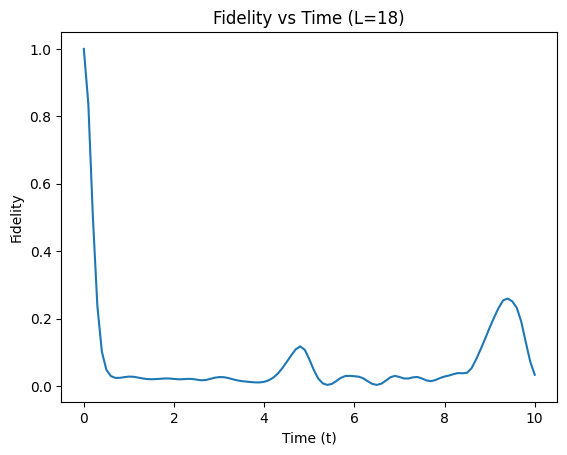

In [4]:
def neel_state(L):
    state = 1
    for i in range(L):
        if i % 2 == 0:
            state = np.kron(state, np.array([1, 0]))  # ↑
        else:
            state = np.kron(state, np.array([0, 1]))  # ↓
    return state

L=18
h=1.0
t_max=10
dt=0.1
H = hamiltonian(L, h)
    
psi0 = neel_state(L).astype(np.complex128)
t_points = np.arange(0, t_max + dt, dt)
fidelity = []

psi_t = psi0.copy()
for t in t_points:
    fid = np.abs(psi0.conj().T @ psi_t) ** 2
    fidelity.append(fid)
    if t < t_max:
        psi_t = expm_multiply(-1j * H * dt, psi_t)
plt.plot(t_points, fidelity)
plt.xlabel('Time (t)')
plt.ylabel('Fidelity')
plt.title('Fidelity vs Time (L=18)')
plt.show()